# Data science with geolocation data

<i>By Diego Ramallo</i>


<img src="https://dl.dropboxusercontent.com/u/59776078/data_science/data_science/map-525349_1920.png" alt="Drawing" style="width: 350px;"/>

Here I will play around with some geolocation data and see if I can visualize it, calculate travel times with it, and hopefully, test some ML on it.

A good source for this type of data is the [SF OpenData](#https://data.sfgov.org/Transportation/NextMuni-vehicle-prediction-data/fam4-k899) repository which has a MUNI dataset. This can give me a good resource for mapping locations around San Francisco.

[Accessing Data](#Accessing Data)

[Using the Google Maps API](#Using the Google Maps API)

[Formatting Data](#Formatting Data)

[Visualize Locations](#Visualize Locations)

## Accessing Data

<a id='Accessing Data'></a>

In [1]:
import numpy as np#Math library
import pandas as pd#Table library
import matplotlib.pyplot as plt#Plotting library
import pandas as pd
import warnings
import seaborn as sns#Plotting library
warnings.filterwarnings('ignore')#Gets rid of popup warnings
%matplotlib nbagg

In [2]:
#Take subset of data to generate locations for drivers and riders using
#the MUNI stop data file
locData= pd.read_table('google_transit/stops.txt', delimiter= ',')

riders= locData[['stop_id','stop_lat','stop_lon']].sample(n= 100, random_state= 42)
drivers= locData[['stop_id','stop_lat','stop_lon']].sample(n= 20, random_state= 24)
riders.head(5)

,stop_id,stop_lat,stop_lon
354,3283,37.764579,-122.428523
3588,6601,37.789062,-122.410316
416,3346,37.762701,-122.395422
2694,5706,37.775710,-122.446360
3277,6290,37.794180,-122.400282


## Using the Google Maps API

<a id='Using the Google Maps API'></a>

It's really nice that Google allows you to use Google Maps API library to visualize objects, but it does require [generating an API key](https://developers.google.com/maps/get-started/) and enabling the specific API's that you'll use (at a minimum the JavaScript API).

Finally, to enable the maps widget in a Jupyter notebook, I'll need to install the gmaps library. Here are the [installation instructions](#http://jupyter-gmaps.readthedocs.io/en/latest/).

In [3]:
#Import gmaps for embedding google maps in a jupyter notebook and summon API key
import os
import gmaps

#The gmaps installation instructions mentioned that your API key
#should not be shared so I instead listed it in my .bash_profile
#document and am calling it from here
gmaps.configure(api_key=os.environ['GOOGLE_API_KEY'])

## Formatting Data

<a id='Formatting Data'></a>

In order to relay the information to gmaps, we'll need to reformat the data in our pandas dataframes to a list of lat/long tuples to be able to read the coordinates.

In [4]:
#Format driver lat/long to list of tuples to use them
#with the gmaps library
driverData = drivers[['stop_lat','stop_lon']]
driverData= [tuple(i) for i in driverData.values]
driverData[0:5]

#Same for riders
riderData = riders[['stop_lat','stop_lon']]
riderData= [tuple(i) for i in riderData.values]
riderData[0:5]

[(37.764578999999998, -122.428523),
 (37.789062000000001, -122.41031599999999),
 (37.762701, -122.395422),
 (37.775709999999997, -122.44636000000001),
 (37.794179999999997, -122.400282)]

## Visualize Locations

<a id='Visualize Locations'></a>

In [5]:
#Define plot layers for drivers and riders
#Make driver markers green and rider markers red
driverLayer = gmaps.symbol_layer(
    driverData, fill_color="green", stroke_color="green", scale=2)

riderLayer= gmaps.symbol_layer(
    riderData, fill_color="red", stroke_color="red", scale=2)

In [6]:
#Initialize map object to plot points 
sfMap= gmaps.Map()

#Apply layers to map
sfMap.add_layer(driverLayer)
sfMap.add_layer(riderLayer)

#Could also generate heatmap with line below
#heatmap_layer = gmaps.Heatmap(data=driverData)

#Show map
sfMap

Sweet it worked! :) It doesn't look like it shows up on Github but it's there!

## Segmenting Riders into Clusters

Now that I know where the riders are and where the drivers are, I'll try to segment them to optimize their locations. 

To begin with, I will assume that I have 20 clusters since I have 20 drivers and use K-Means as a first pass segmentation tool. This will cluster riders based on their distance to the drivers.

In [115]:
len(driverData)

20

In [12]:
#Import kmeans
from sklearn.cluster import KMeans

#Initialize kmeans object, making sure to specify INITIAL cluster
#centroids as driverData (as an array)
kmeans= KMeans(n_clusters= len(driverData), init= np.array(driverData))

#Apply kmeans clustering and look at the labels
kmeans.fit(riderData)
kmeans.labels_

array([ 8,  1,  9,  0,  1,  3,  7, 10,  6, 13,  2, 13, 10,  6, 18,  5, 13,
       17, 17,  0, 11,  7,  5,  2,  7,  5,  2,  1, 16, 15,  6, 13,  9,  2,
       19,  7, 13, 11, 12, 11,  6,  7,  7,  1,  6, 13,  3,  1,  3,  8,  2,
       15, 10, 19,  8, 15,  1,  6, 19,  2,  2,  1, 13,  3,  3,  5,  2, 18,
       10,  6,  9, 10,  4,  6,  1,  8,  9,  1,  9, 13, 17,  6,  0,  4,  3,
        5,  1,  4,  6,  2, 14,  9, 13,  1,  8,  0,  8, 11, 19, 10], dtype=int32)

Excellent, now that we've clustered the riders, let's see how they were distributed with a histogram.

<IPython.core.display.Javascript object>


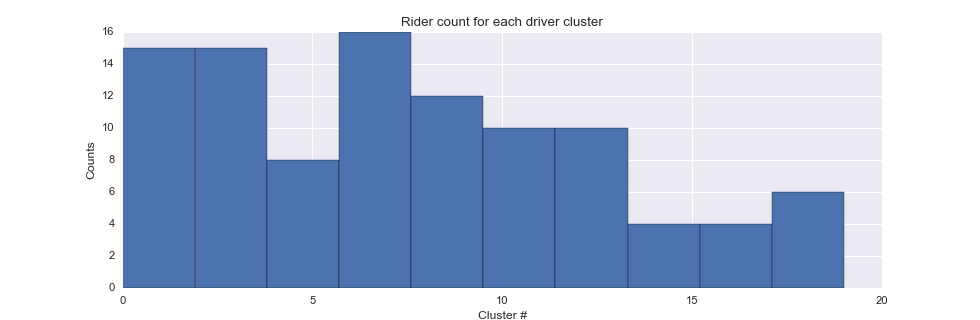

In [14]:
plt.hist(kmeans.labels_)
plt.xlabel('Cluster #')
plt.ylabel('Counts')
plt.title('Rider count for each driver cluster')

Looks pretty well distributed. There were some cars that were far from everything else so we wouldn't expect them to get an equal # of riders. Let's see where the final centroids were.

In [33]:
#Get centroids, turn them into a list of tuple pairs
newCentroids= kmeans.cluster_centers_
newCentroids= map(tuple,newCentroids)

centroidLayer= gmaps.symbol_layer(
    newCentroids, fill_color=None, stroke_color="yellow", scale=2)

In [34]:
#Plot the new centroids on map
sfMap.add_layer(driverLayer)
sfMap.add_layer(centroidLayer)
sfMap